# Image Registration using SIFT Detectors

The goal of this project, is to investigate and better understand image registration. For this purpose, batch of unregistered brain images is used as a data set. In the end I want to have an aligned version of each image to enable downstream tasks like 3D reconstruction.

![A stack of images](./supplementary/stacking.png)

# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import jupyter_black
import utils
from tqdm import tqdm
import heapq

jupyter_black.load()

# Preperation and Image loading

In [2]:
DATA_PATH = "data/png/"

In [3]:
all_images = utils.read_images(DATA_PATH)
print(f"{len(all_images)} images loaded")

26 images loaded


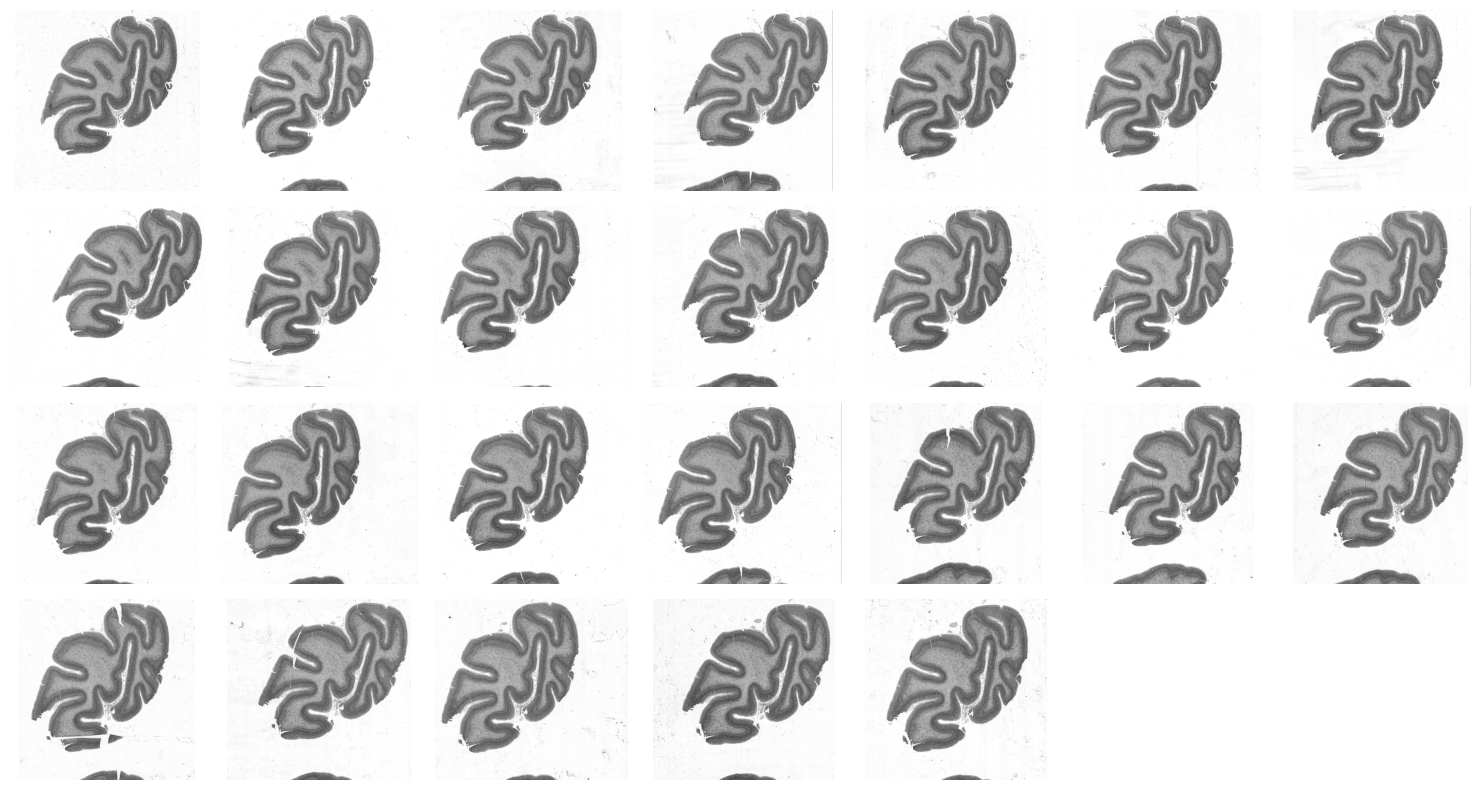

In [4]:
plt.figure(figsize=(15, 8))
for i, img in enumerate(all_images):
    plt.subplot(4, 7, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

Here I put the first image at the end. This is done, because the second image is more similar to all other images. Since the first image in the list will be used as a reference image later on, I found it to be beneficial if it is more similar to the rest of the images.

In [5]:
all_images = all_images[1:] + all_images[:1]

# Define Testing Images

In [6]:
ref_img_idx = -1
test_img_idx = 0

# 1) Detecting Features

In [7]:
def find_kp_and_des(images: list):
    sift = cv2.SIFT_create()
    kp_and_des = []
    for img in tqdm(images, desc="Finding keypoints and descriptors", unit="image"):
        kp, des = sift.detectAndCompute(img, None)
        kp_and_des.append((kp, des))
    return kp_and_des

Finding keypoints and descriptors: 100%|██████████| 26/26 [00:07<00:00,  3.40image/s]


Number of keypoints in ref image: 8155


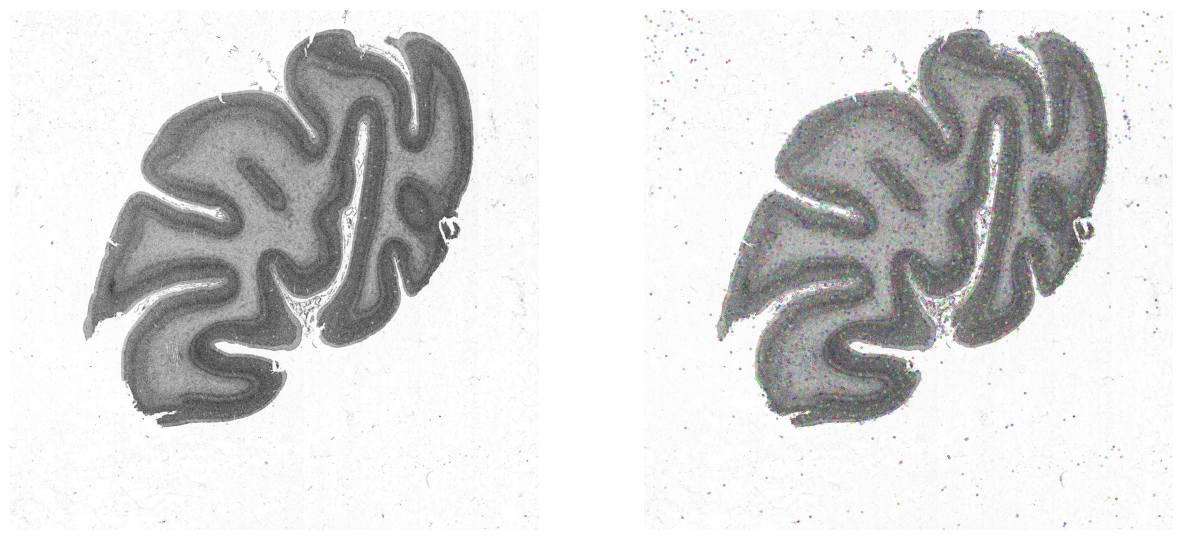

In [8]:
kp_and_des = find_kp_and_des(all_images)
print(f"Number of keypoints in ref image: {len(kp_and_des[ref_img_idx][0])}")
gray = all_images[ref_img_idx]
kp = kp_and_des[ref_img_idx][0]
img = cv2.drawKeypoints(gray, kp, gray)
utils.show_images([gray, img], figsize=(15, 7))

The coloured dots represent the points of interest found. As one can see, there are many outliers. The next step is to find these POIs for each image.

# 2) Feature matching

In [9]:
# Faster implementation of Euclidean distances using numpy than sklearn
def euclidean_distances_numpy(X, Y):
    # Compute the squared Euclidean distances
    dists = (
        -2 * np.dot(X, Y.T) + np.sum(Y**2, axis=1) + np.sum(X**2, axis=1)[:, np.newaxis]
    )

    # Take the square root to get the Euclidean distances
    dists = np.sqrt(dists)

    return dists


def match_keypoints(kp_and_des1, kp_and_des2, max_ratio=0.6) -> list:
    # Compute the Euclidean distances between the descriptors of the keypoints
    dist_mat = euclidean_distances_numpy(kp_and_des1[1], kp_and_des2[1])

    # using heapq, because it is faster than numpy
    smallest_and_second_smallest = [heapq.nsmallest(2, row) for row in dist_mat]
    smallest_dist, second_smallest_dist = np.transpose(smallest_and_second_smallest)

    # Add a small constant to avoid division by zero
    smallest_dist += 1e-8
    second_smallest_dist += 1e-8

    # Compute the ratio of the smallest distance to the second smallest distance
    ratio = smallest_dist / second_smallest_dist

    # Get the indices of the keypoints that satisfy the ratio test
    mask = ratio < max_ratio
    idx1 = np.arange(len(mask))[mask]
    idx2 = np.argmin(dist_mat[mask], axis=1)

    # Create a list of DMatch objects
    dm = [cv2.DMatch(i1, i2, 0) for i1, i2 in zip(idx1, idx2)]

    return dm

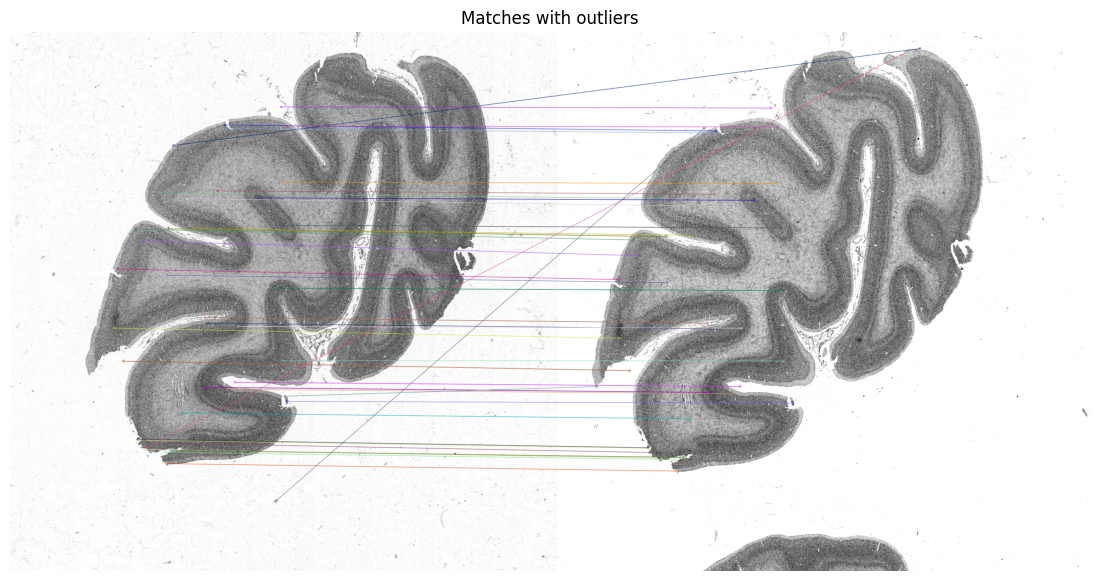

In [10]:
dm = match_keypoints(kp_and_des[ref_img_idx], kp_and_des[test_img_idx])

# draw matches
img = cv2.drawMatches(
    all_images[ref_img_idx],
    kp_and_des[ref_img_idx][0],
    all_images[test_img_idx],
    kp_and_des[test_img_idx][0],
    dm[:50],
    None,
    flags=2,
)

utils.show_image(img, figsize=(15, 7), title="Matches with outliers")

When testing the match on a translated version of an image of a tree, the algorithm found good keypoints that should be enough to register the two images. Strangely, the algorithm only found keypoints for a tree that was not even in the focus/centre of the image.

![A stack of images](./supplementary/tree_matching.png)

# 3+4) Removing outliers and calulating the transformation matrix

RANSAC loop: 
1. Select four feature pairs (at random) 
2. Compute homography H (exact) 
3. Compute inliers where $SSD(p_i', H p_i) < \epsilon$
   
   (loop 1-3)
   
4. Keep largest set of inliers 
5. Re-compute least-squares H estimate on all of the 
inliers

Link for calculating Homography matrix: https://www.cs.cmu.edu/%7E16385/lectures/lecture9.pdf

In [11]:
def calc_homography(pts1, pts2):
    # pts1 and pts2 are lists of corresponding coordinates

    # Convert the lists to numpy arrays
    if isinstance(pts1, list):
        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

    # Compute the homography matrix
    H, _ = cv2.findHomography(pts1, pts2, 0)

    return H

In [12]:
def ransac(
    dm: list,
    kp_and_des_1: list,
    kp_and_des_2: list,
    n_iterations=100,
    eps=5,
    verbose=False,
):
    """
    Performs RANSAC (Random Sample Consensus) algorithm to estimate a homography matrix between two sets of keypoints.

    Args:
        dm (list): List of matches between keypoints in the two images.
        kp_and_des_1 (list): List containing keypoints and descriptors of the first image.
        kp_and_des_2 (list): List containing keypoints and descriptors of the second image.
        n_iterations (int, optional): Number of iterations to run RANSAC. Defaults to 100.
        eps (float, optional): Maximum distance threshold for a point to be considered an inlier. Defaults to 5.
        verbose (bool, optional): If True, prints the percentage of inliers. Defaults to False.

    Returns:
        tuple: A tuple containing the best homography matrix and the inliers.
    """
    best_inliers = None
    best_n_inliers = 0

    for _ in range(n_iterations):
        # randomly select 4 matches
        random_matches = np.random.choice(dm, 4, replace=False)
        pts1 = np.array([kp_and_des_1[0][m.queryIdx].pt for m in random_matches])
        pts2 = np.array([kp_and_des_2[0][m.trainIdx].pt for m in random_matches])

        # compute homography from pts2 to pts1
        H = calc_homography(pts2, pts1)

        # apply homography to all points
        pts1 = np.array([kp_and_des_1[0][m.queryIdx].pt for m in dm])
        pts2 = np.array([kp_and_des_2[0][m.trainIdx].pt for m in dm])

        # transform points
        try:
            pts2_transformed = cv2.perspectiveTransform(
                np.array([pts2], dtype=np.float32), H
            ).squeeze()
        except:
            pass

        # calculate the distance between transformed points and original points
        dist = np.linalg.norm(pts2_transformed - pts1, axis=1)

        # get inliers. dm ist a python list
        inliers = [dm[i] for i in range(len(dm)) if dist[i] < eps]

        # get number of inliers
        n_inliers = len(inliers)

        # update best homography and inliers
        if n_inliers > best_n_inliers:
            best_n_inliers = n_inliers
            best_inliers = inliers

    # calc H on all inliers
    pts1 = np.array([kp_and_des_1[0][m.queryIdx].pt for m in best_inliers])
    pts2 = np.array([kp_and_des_2[0][m.trainIdx].pt for m in best_inliers])
    best_H = calc_homography(pts2, pts1)

    if verbose:
        print(f"Percentage of inliers: {best_n_inliers / len(dm) * 100:.2f}%")

    return best_H, best_inliers


# get best homography and inliers
H, inliers = ransac(
    dm,
    kp_and_des[ref_img_idx],
    kp_and_des[test_img_idx],
    n_iterations=1000,
    eps=2,
    verbose=True,
)

Percentage of inliers: 42.28%


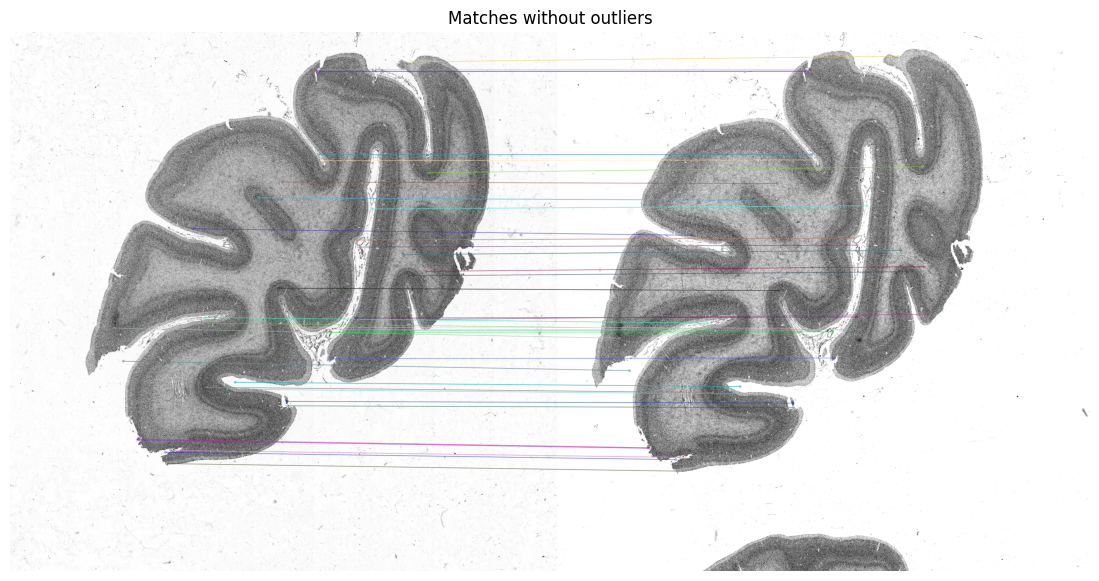

In [13]:
# draw matches
img = cv2.drawMatches(
    all_images[ref_img_idx],
    kp_and_des[ref_img_idx][0],
    all_images[test_img_idx],
    kp_and_des[test_img_idx][0],
    inliers[:50],
    None,
    flags=2,
)

utils.show_image(img, figsize=(15, 7), title="Matches without outliers")

# 5) Image transformation

In [14]:
def overlay_images(imgs: list):
    base_image = imgs[0].copy()
    base_shape = base_image.shape
    factor = 1 / len(imgs)

    overlay_image = base_image * factor

    for img in imgs[1:]:
        # resize img to base_shape
        img = cv2.resize(img, (base_shape[1], base_shape[0]))
        overlay_image += img * factor

    return overlay_image.astype(np.uint8)

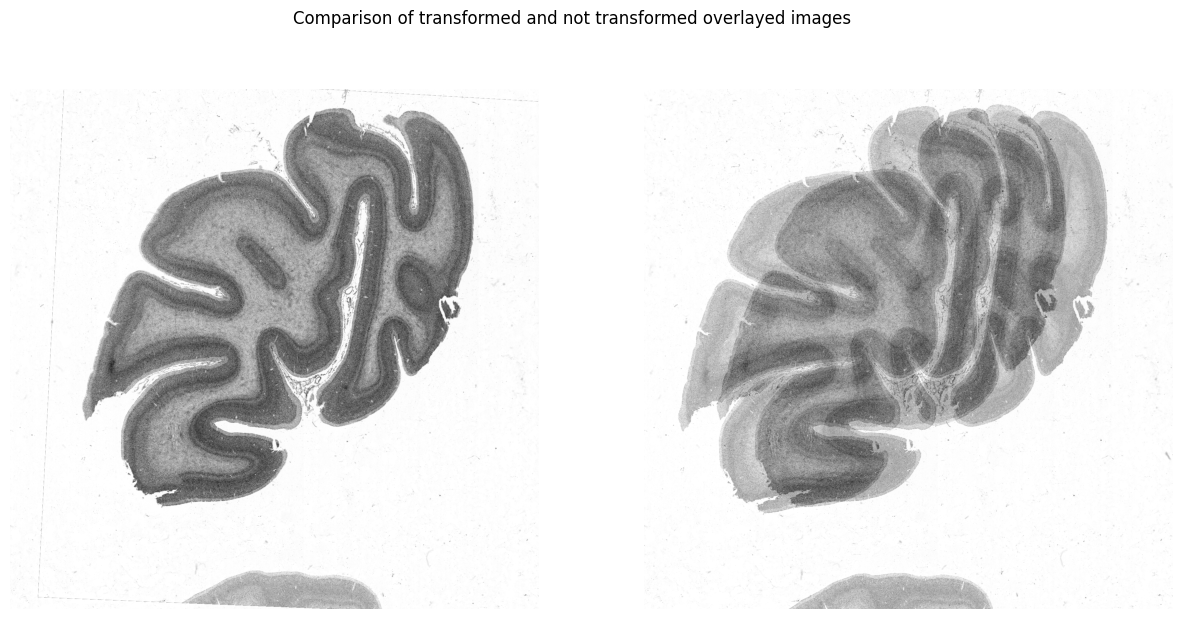

In [23]:
def align_images(img1, img2, H):
    """
    Aligns two images using a homography matrix.

    Args:
        img1 (numpy.ndarray): The first image.
        img2 (numpy.ndarray): The second image.
        H (numpy.ndarray): The homography matrix.

    Returns:
        numpy.ndarray: The aligned image.
    """
    # transform the second image to match the first image
    transformed_image = cv2.warpPerspective(
        img2, H, (img1.shape[1], img1.shape[0]), cv2.WARP_INVERSE_MAP
    )
    # fill black pixels white
    transformed_image[transformed_image == 0] = 255
    return transformed_image


# get copies of the first two images
img1 = all_images[ref_img_idx].copy()
img2 = all_images[test_img_idx].copy()

transformed_img2 = align_images(img1, img2, H)
blended = overlay_images([img1, transformed_img2])

# for comparison and visualization of effect, we can also blend the two images without transformation
# change size of img2 to size of img1
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
before_blend = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)

utils.show_images(
    [blended, before_blend],
    title="Comparison of transformed and not transformed overlayed images",
    figsize=(15, 7),
)

# Generalization to N images

Baseline: Simply overlaying all images

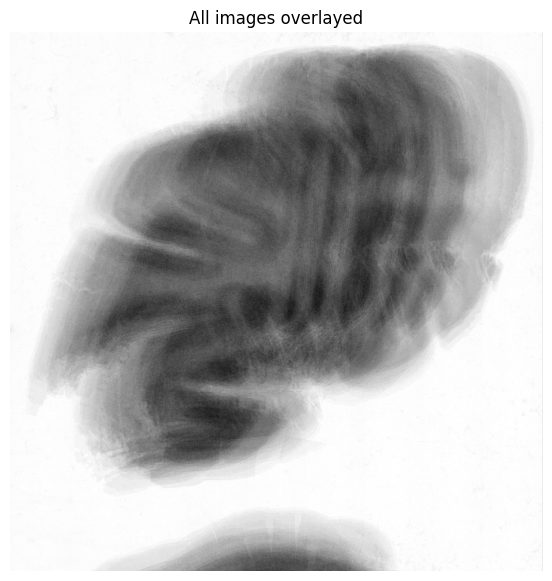

In [15]:
all_overlay = overlay_images(all_images)

utils.show_image(all_overlay, title="All images overlayed", figsize=(15, 7))

In [24]:
# register all images
def register_images(images: list, ransac_iterations=1_000, ransac_eps=3):
    """
    Register a list of images by performing keypoint matching, homography estimation, and image alignment.

    Args:
        images (list): A list of images to be registered. The first image in the list is used as the reference image.

    Returns:
        tuple: A tuple containing the overlay image and a list of aligned images.

    """
    # the first image is the reference image
    ref_img = images[0]

    # find keypoints and descriptors for all images
    kp_and_des = find_kp_and_des(images)
    ref_kp_and_des = kp_and_des[0]

    # find all matches for all images
    all_matches = []
    for idx in tqdm(range(1, len(images)), desc="Finding matches", unit="image"):
        dm = match_keypoints(ref_kp_and_des, kp_and_des[idx])
        all_matches.append(dm)

    # find homography and inliers for all images
    all_homographies = []
    all_inliers = []
    for idx, dm in enumerate(
        tqdm(all_matches, desc="Finding homographies", unit="image"), start=1
    ):
        H, inliers = ransac(
            dm,
            ref_kp_and_des,
            kp_and_des[idx],
            n_iterations=ransac_iterations,
            eps=ransac_eps,
            verbose=False,
        )
        all_homographies.append(H)
        all_inliers.append(inliers)

    # align all images
    aligned_images = [ref_img]
    for idx, img in enumerate(tqdm(images[1:], desc="Aligning images", unit="image")):
        aligned_img = align_images(ref_img, img, all_homographies[idx])
        aligned_images.append(aligned_img)

    # overlay all images
    all_overlay = overlay_images(aligned_images)

    return all_overlay, aligned_images

In [28]:
all_overlay, aligned_images = register_images(
    all_images, ransac_iterations=5_000, ransac_eps=15
)

Aligning images: 100%|██████████| 25/25 [00:00<00:00, 129.56image/s]


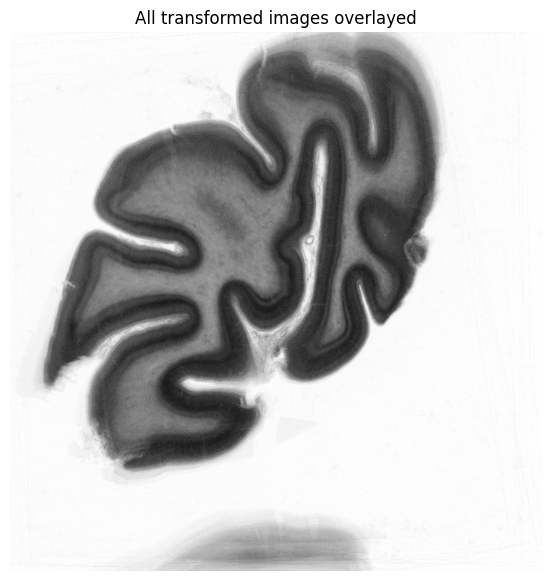

In [30]:
utils.show_image(all_overlay, title="All transformed images overlayed", figsize=(15, 7))

# Final result

With just a few adjustments to the final image (a few white boxes placed over the ‘unsightly’ edges), a good end result of all 26 overlayed images can be achieved.

(This image is generated without replacing the black pixels with white pixels.)

<img src="./supplementary/adjusted_overlay.png" alt="Adjusted Overlay" height="500">